In [2]:
import tensorflow as tf
import numpy as np
import keras
# import wget
# from pathlib import Path
from typing import List#, Union
# import zipfile
# import SimpleITK as sitk
# import nibabel as nib
import pydicom
import cv2
# import functools

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import BatchNormalization

from keras.layers import Conv2DTranspose
from keras.layers import concatenate

# import tensorflow_io as tfio

from keras.models import load_model
from keras.models import model_from_json

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

from keras.utils import get_custom_objects

# import os
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import yaml


2024-12-02 13:35:59.398121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 13:36:01.378081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [4]:
# def display_outputs(display_list):
#     plt.figure(figsize=(15, 15))

#     title = ['Input Mask Image', 'Input CT Image', 'True Mask','Predicted Mask','','']

#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(title[i])
#         # plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         plt.imshow(display_list[i])
#         plt.axis('off')
#     plt.show()
    
# def show_predictions(model,dataset=None, num=1):
#     """
#     Displays the first image of each of the num batches
#     """
#     if dataset:
#         for image, mask in dataset.take(num):
#             print(image[0].shape)
#             pred_mask = model.predict(image, batch_size=1)
#             print(create_mask(pred_mask).shape)
#             # display_outputs([image[0,:,:,0], image[0,:,:,1], image[0,:,:,2],image[0,:,:,3],mask[0]])
#             # display_outputs([image[0,:,:,0],image[0,:,:,1], mask[0], create_mask(pred_mask)[0]])
#             display_outputs([image[0,:,:,0],image[0,:,:,1], mask[0], create_mask(pred_mask)[0]])
            
#             y_true_one_hot =  tf.one_hot(tf.cast(mask,tf.uint8), depth=9, axis=-1)
#             for index in range(9):
#                 print(str(index) + ':    ' + str(dice_coef(y_true_one_hot[:,:,:,index], pred_mask[:,:,:,index]).numpy()))
#                 # print()
#             # from keras import backend as K

In [5]:
## Apply Windowing to CT Images, Stack Images

def _window(xs, c2c_mask, bounds):
    """Apply windowing to an array of CT images.

    Args:
        xs (ndarray): NxHxW
        mask (ndarray): NxHxW
        bounds (tuple): (lower, upper) bounds

    Returns:
        ndarray: Windowed images.
    """

    imgs = []
    imgs.append(c2c_mask) #/ 255) # Normalize mask input from 0 to 1
    for lb, ub in bounds:
        imgs.append(np.clip(xs, a_min=lb, a_max=ub))
    # print(len(imgs))
    if len(imgs) == 1:
        return np.expand_dims(imgs[0],axis=-1)
    elif xs.shape[-1] == 1:
        return np.concatenate(imgs, axis=-1)
    else:
        return np.stack(imgs, axis=-1)

In [6]:
## Function from Comp2Comp 
def parse_windows(windows):
    """Parse windows provided by the user.

    These windows can either be strings corresponding to popular windowing
    thresholds for CT or tuples of (upper, lower) bounds.

    Args:
        windows (list): List of strings or tuples.

    Returns:
        list: List of tuples of (upper, lower) bounds.
    """
    windowing = {
        "soft": (400, 50),
        "bone": (1800, 400),
        "liver": (150, 30),
        "spine": (250, 50),
        "custom": (500, 50),
    }
    # print(windows)
    vals = []
    for w in windows:
        # print(w)
        w=w.decode('utf-8')
        # print(w)
        if len(w) == 2:
            assert_msg = "Expected tuple of (lower, upper) bound"
            assert len(w) == 2, assert_msg
            assert isinstance(w[0], (float, int)), assert_msg
            assert isinstance(w[1], (float, int)), assert_msg
            assert w[0] < w[1], assert_msg
            vals.append(w)
            continue

        if w not in windowing:
            raise KeyError("Window {} not found".format(w))
        window_width = windowing[w][0]
        window_level = windowing[w][1]
        upper = window_level + window_width / 2
        lower = window_level - window_width / 2

        vals.append((lower, upper))

    return tuple(vals)

In [7]:
def process_path_C2C(image_path, c2c_mask_path, mask_path):
    image_path = image_path.numpy().decode("utf-8")
    c2c_mask_path = c2c_mask_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")
    img = pydicom.read_file(image_path, force=True)
    img = (img.pixel_array + int(img.RescaleIntercept)).astype("float32")
    c2c_mask = pydicom.read_file(c2c_mask_path, force=True)
    c2c_mask = (c2c_mask.pixel_array).astype("float32")
    mask = pydicom.read_file(mask_path, force=True)
    mask = (mask.pixel_array + int(mask.RescaleIntercept)).astype("float32")

    return img, c2c_mask, mask

def tf_process_path_C2C(image_path, c2c_mask_path, mask_path):
    return tf.py_function(process_path_C2C, [image_path, c2c_mask_path, mask_path], [tf.float32, tf.float32, tf.float32])

def preprocess_C2C(image, c2c_mask, mask, windows):#=['soft','bone','custom']):
    
    # windows = tf.py_function(parse_windows,[windows],[tf.float32])
    # print(windows.numpy().tolist())
    window_imgs = _window(image, c2c_mask, parse_windows(windows.numpy().tolist()))
    return window_imgs, mask

def tf_preprocess_C2C(image, c2c_mask, mask, windows):
    print(windows)
    return tf.py_function(preprocess_C2C, [image, c2c_mask, mask, windows], [tf.float32, tf.float32])



In [8]:
# from keras import backend as K
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=9):
    dice=0
    y_true_one_hot =  tf.one_hot(tf.cast(y_true,tf.uint8), depth=numLabels, axis=-1)
    for index in range(numLabels):
        # dice -= dice_coef(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index])
        weight = 1/ tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,:,index]))
        dice -= weight * dice_coef(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index])
    # for index in range(numLabels-1):
    #     dice -= dice_coef(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index])
    #     # weight = 1/ tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,:,index+1]))
    #     # dice -= weight * dice_coef(y_true_one_hot[:,:,:,index+1], y_pred[:,:,:,index+1])
        
    return dice

In [9]:
from keras.losses import binary_crossentropy
# import SimpleITK as sitk
from  scipy import ndimage

# signed_distance_filter = sitk.SignedMaurerDistanceMapImageFilter()
# signed_distance_filter.SetSquaredDistance(False)
# # print('inside is positive:', signed_distance_filter.GetInsideIsPositive())
# print('use image spacing:', signed_distance_filter.GetUseImageSpacing())

# def signed_dist_map(y_true):
#     return ndimage.distance_transform_edt(1 - y_true) ** (1/2)

# def signed_distance(y_true, y_pred):
#     y_true_f = tf.keras.backend.flatten(signed_dist_map(y_true))
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     return  tf.keras.backend.sum(tf.cast(y_true_f,tf.float32)* y_pred_f)
    
# def signed_distance_multilabel(y_true, y_pred, numLabels=9):
#     sign_dist_loss = 0
#     y_true_one_hot =  tf.one_hot(tf.cast(y_true,tf.uint8), depth=numLabels, axis=-1)
#     for index in range(numLabels-1):
#         weight = 1/ tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,index+1]))
#         sign_dist_loss += weight * signed_distance(y_true_one_hot[:,:,index+1], y_pred[:,:,index+1])
def distance_transform_edt_tf(tensor):
    def numpy_distance_transform(input_array):
        return ndimage.distance_transform_edt(input_array).astype(np.float32)
    
    # Use tf.py_function to apply the numpy function
    result = tf.py_function(numpy_distance_transform, [tensor], tf.float32)
    # Ensure shape propagation
    result.set_shape(tensor.shape)
    return result

def signed_dist_map(y_true):
    return tf.keras.backend.pow(distance_transform_edt_tf(1 - y_true), 0.6)

def signed_distance(y_true, y_pred):
    y_true_f = 1 + tf.keras.backend.flatten(signed_dist_map(y_true))
    y_pred_f = tf.keras.backend.flatten(y_pred)
    return tf.keras.backend.sum(tf.cast(y_true_f,tf.float32) * y_pred_f)
    
def signed_distance_multilabel(y_true, y_pred, numLabels=9):
    sign_dist_loss = 0
    y_true_one_hot =  tf.one_hot(tf.cast(y_true,tf.uint8), depth=numLabels, axis=-1)
    for index in range(numLabels-1):
        weight = 1/ tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,index+1]))
        # print(y_true_one_hot[:,:,:,index+1].shape)
        # print(y_pred[:,:,:,index+1].shape)

        # signed_distance(y_true_one_hot[:,:,:,index+1], y_pred[:,:,:,index+1])
        sign_dist_loss += weight * signed_distance(y_true_one_hot[:,:,index+1], y_pred[:,:,index+1])#signed_distance(y_true_one_hot[:,:,:,index+1], y_pred[:,:,:,index+1])
    
    return sign_dist_loss

def dice_dist_multilabel(y_true, y_pred, numLabels=9):
    return signed_distance_multilabel(y_true, y_pred, numLabels) + (1e6)*dice_coef_multilabel(y_true, y_pred, numLabels)


In [10]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the confusion matrix as an image.
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Annotate cells with values
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    return figure
    
def log_confusion_matrix(model,dataset=None,num_classes=9):
# Unpack validation data
    if dataset:
        data, labels = dataset
        predictions = model.predict(data[0])
        # pred_mask = model.predict(image, batch_size=1)

        predictions = tf.argmax(predictions, axis=-1)

        # Compute confusion matrix
        cm = tf.math.confusion_matrix(
            tf.reshape(labels, [-1]),
            tf.reshape(predictions, [-1]),
            num_classes=9
        ).numpy()

        # Plot the confusion matrix
        figure = plot_confusion_matrix(cm, class_names=[f"Class {i}" for i in range(num_classes)])


In [11]:
def display_outputs(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Mask Image', 'Input CT Image', 'Loss Map','True Mask','Predicted Mask','','']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        # plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    
def show_predictions(model,dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        try:
            for image, mask in dataset.take(num):
                print(image[0].shape)
                pred_mask = model.predict(image, batch_size=1)
                print(create_mask(pred_mask).shape)
                # display_outputs([image[0,:,:,0], image[0,:,:,1], image[0,:,:,2],image[0,:,:,3],mask[0]])
                # display_outputs([image[0,:,:,0],image[0,:,:,1], mask[0], create_mask(pred_mask)[0]])
                y_true_one_hot =  tf.one_hot(tf.cast(mask,tf.uint8), depth=9, axis=-1)

                map = signed_dist_map(y_true_one_hot[0,:,:,8])
                display_outputs([image[0,:,:,0],image[0,:,:,1],map, mask[0], create_mask(pred_mask)[0]])
                print(signed_distance(y_true_one_hot[0,:,:,4], pred_mask[0,:,:,4]))
                for index in range(9):
                    print(str(index) + ':    ' + str(dice_coef(y_true_one_hot[:,:,:,index], pred_mask[:,:,:,index]).numpy()))
                    # print()
        except:
            image, mask = dataset
            print(image[0].shape)
            pred_mask = model.predict(image, batch_size=1)
            print(create_mask(pred_mask).shape)
            # display_outputs([image[0,:,:,0], image[0,:,:,1], image[0,:,:,2],image[0,:,:,3],mask[0]])
            # display_outputs([image[0,:,:,0],image[0,:,:,1], mask[0], create_mask(pred_mask)[0]])
            y_true_one_hot =  tf.one_hot(tf.cast(mask,tf.uint8), depth=9, axis=-1)

            map = signed_dist_map(y_true_one_hot[0,:,:,8])
            display_outputs([image[0,:,:,0],image[0,:,:,1],map, mask[0], create_mask(pred_mask)[0]])
            # print(signed_distance(y_true_one_hot[0,:,:,4], pred_mask[0,:,:,4]))
            for index in range(9):
                print(str(index) + ':    ' + str(dice_coef(y_true_one_hot[:,:,:,index], pred_mask[:,:,:,index]).numpy()))
                # print()
    
            # from keras import backend as K

In [12]:
def signed_dist_map_x2_x05(y_true):
    map = distance_transform_edt_tf(1 - y_true)
    return tf.keras.backend.pow(map, 2) + tf.keras.backend.pow(map,0.5)

def signed_dist_map_2x(y_true):
    return 2*distance_transform_edt_tf(1 - y_true)


def signed_distance(y_true, y_pred,map):

    y_true_f = 1 + tf.keras.backend.flatten(map(y_true))
    y_pred_f = tf.keras.backend.flatten(y_pred)
    return tf.keras.backend.sum(tf.cast(y_true_f,tf.float32) * y_pred_f)
    
def signed_distance_multilabel(y_true, y_pred, map_name,numLabels=9):
    map_functions = {
    "signed_dist_map": signed_dist_map,
    "signed_dist_map_x2_x05": signed_dist_map_x2_x05,
    "signed_dist_map_2x": signed_dist_map_2x
    }   
    
    sign_dist_loss = 0
    y_true_one_hot =  tf.one_hot(tf.cast(y_true,tf.uint8), depth=numLabels, axis=-1)
    for index in range(numLabels):#range(numLabels-1):
        weight = 1/ tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,:,index]))#tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,:,index+1]))
        # print(y_true_one_hot[:,:,:,index+1].shape)
        # print(y_pred[:,:,:,index+1].shape)
        sign_dist_loss += weight * signed_distance(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index],map_functions[map_name])#signed_distance(y_true_one_hot[:,:,:,index+1], y_pred[:,:,:,index+1])#signed_distance(y_true_one_hot[:,:,:,index+1], y_pred[:,:,:,index+1])
    
    return sign_dist_loss

def dice_dist_multilabel(y_true, y_pred, numLabels=9):
    return signed_distance_multilabel(y_true, y_pred,"signed_dist_map",numLabels,) + (1e7)*dice_coef_multilabel(y_true, y_pred, numLabels)

def dice_dist_multilabel_2x(y_true, y_pred, numLabels=9):
    return signed_distance_multilabel(y_true, y_pred, "signed_dist_map_2x",numLabels) + (1e6)*dice_coef_multilabel(y_true, y_pred, numLabels)

def dice_dist_multilabel_x2_x05(y_true, y_pred, numLabels=9):
    return signed_distance_multilabel(y_true, y_pred,"signed_dist_map_x2_x05", numLabels) + (1e6)*dice_coef_multilabel(y_true, y_pred, numLabels)


In [13]:
# import tensorflow as tf
# import numpy as np
# import io
# import matplotlib.pyplot as plt

# class ConfusionMatrixTensorBoard(tf.keras.callbacks.Callback):
#     def __init__(self, log_dir, validation_data, num_classes):
#         super().__init__()
#         self.log_dir = log_dir
#         self.validation_data = validation_data
#         self.num_classes = num_classes
#         self.file_writer = tf.summary.create_file_writer(log_dir)

#     def plot_confusion_matrix(self, cm, class_names):
#         """
#         Returns a matplotlib figure containing the confusion matrix as an image.
#         """
#         figure = plt.figure(figsize=(8, 8))
#         plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
#         plt.title("Confusion Matrix")
#         plt.colorbar()
#         tick_marks = np.arange(len(class_names))
#         plt.xticks(tick_marks, class_names, rotation=45)
#         plt.yticks(tick_marks, class_names)

#         # Normalize the confusion matrix
#         cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

#         # Annotate cells with values
#         thresh = cm.max() / 2.0
#         for i, j in np.ndindex(cm.shape):
#             plt.text(j, i, f"{cm[i, j]:.2f}",
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         plt.ylabel("True Label")
#         plt.xlabel("Predicted Label")
#         plt.tight_layout()
#         return figure

#     def log_confusion_matrix(self, epoch, logs=None):
#         # Unpack validation data
#         val_data, val_labels = self.validation_data
#         val_predictions = self.model.predict(val_data)
#         val_predictions = tf.argmax(val_predictions, axis=-1)

#         # Compute confusion matrix
#         cm = tf.math.confusion_matrix(
#             tf.reshape(val_labels, [-1]),
#             tf.reshape(val_predictions, [-1]),
#             num_classes=self.num_classes
#         ).numpy()

#         # Plot the confusion matrix
#         figure = self.plot_confusion_matrix(cm, class_names=[f"Class {i}" for i in range(self.num_classes)])

#         # Convert the plot to a TensorFlow image
#         buf = io.BytesIO()
#         plt.savefig(buf, format="png")
#         plt.close(figure)
#         buf.seek(0)
#         image = tf.image.decode_png(buf.getvalue(), channels=4)
#         image = tf.expand_dims(image, 0)

#         # Log the confusion matrix as an image summary
#         with self.file_writer.as_default():
#             tf.summary.image("Confusion Matrix", image, step=epoch)

#     def on_epoch_end(self, epoch, logs=None):
#         self.log_confusion_matrix(epoch, logs)

In [14]:
# def display_outputs(display_list):
#     plt.figure(figsize=(15, 15))

#     title = ['Input Mask Image', 'Input CT Image', 'True Mask','Predicted Mask','','']

#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(title[i])
#         # plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         plt.imshow(display_list[i])
#         plt.axis('off')
#     plt.show()
#     # plt.colorbar()
    
# def show_predictions(model,dataset=None, num=1):
#     """
#     Displays the first image of each of the num batches
#     """
#     if dataset:
#         for image, mask in dataset.take(num):
#             # print(image[0].shape)
#             pred_mask = model.predict(image, batch_size=1)
#             # print(create_mask(pred_mask).shape)
#             # display_outputs([image[0,:,:,0], image[0,:,:,1], image[0,:,:,2],image[0,:,:,3],mask[0]])
#             # display_outputs([image[0,:,:,0],image[0,:,:,1], mask[0], create_mask(pred_mask)[0]])
#             # display_outputs([image[0,:,:,0],image[0,:,:,1], mask[0], create_mask(pred_mask)[0]])
            
#             y_true_one_hot =  tf.one_hot(tf.cast(mask,tf.uint8), depth=9, axis=-1)
#             for index in range(9):
#                 print(str(index) + ':    ' + str(dice_coef(y_true_one_hot[:,:,:,index], pred_mask[:,:,:,index]).numpy()))
#                 # print()
#             map = signed_dist_map(y_true_one_hot[0,:,:,4])
#             # print(signed_distance_multilabel(y_true_one_hot[:,:,:,4],mask))
#             # print(map.shape)
#             # print(y_true_one_hot[1,:,:,2].numpy().shape)
#             # print(map[0].shape)
#             # print(y_true_one_hot[:,:,:,2].numpy().shape)
#             display_outputs([y_true_one_hot[0,:,:,4].numpy(), map])
#             # from keras import backend as K

In [15]:
image_list = ['./inputs/AC42132bb-AC4213690-CT.dcm',
'./inputs/AC42132bc-AC42164ba-CT.dcm',
'./inputs/AC4213342-AC4213717-CT.dcm',
'./inputs/AC4213402-AC42137d8-CT.dcm',
'./inputs/AC4213416-AC42137ec-CT.dcm',
'./inputs/AC4213422-AC42137f9-CT.dcm',
'./inputs/AC4213461-AC4213839-CT.dcm',
'./inputs/AC42134ec-AC42138c7-CT.dcm',
'./inputs/AC4213a71-AC4213e2b-CT.dcm',
'./inputs/AC4213af5-AC4213eb5-CT.dcm',
'./inputs/AC421420b-AC4243aec-CT.dcm',
'./inputs/AC421427b-AC4214618-CT.dcm',
'./inputs/AC42142d6-AC4243063-CT.dcm',
'./inputs/AC42142f9-AC421469e-CT.dcm',
'./inputs/AC4214306-AC423f75a-CT.dcm',
'./inputs/AC421439b-AC4214750-CT.dcm',
'./inputs/AC4214412-AC42147d2-CT.dcm',
'./inputs/AC4214947-AC4214ccd-CT.dcm',
'./inputs/AC4214a78-AC4214e1f-CT.dcm',
'./inputs/AC4214bfb-AC4214fcf-CT.dcm',
'./inputs/AC4215183-AC4215506-CT.dcm',
'./inputs/AC4215221-AC42155bc-CT.dcm',
'./inputs/AC4215255-AC42155f7-CT.dcm',
'./inputs/AC4215279-AC421561e-CT.dcm',
'./inputs/AC4215897-AC4215bec-CT.dcm',
'./inputs/AC42158a1-AC4240972-CT.dcm',
'./inputs/AC4215999-AC4215d1b-CT.dcm',
'./inputs/AC42159ce-AC4215d52-CT.dcm',
'./inputs/AC4215a72-AC42439ee-CT.dcm',
'./inputs/AC4215a9a-AC4215e57-CT.dcm',
'./inputs/AC4215f4b-AC4216298-CT.dcm',
'./inputs/AC4216026-AC4216397-CT.dcm',
'./inputs/AC4216057-AC42163d0-CT.dcm',
'./inputs/AC4216186-AC4216545-CT.dcm',
'./inputs/AC42161e7-AC42165ba-CT.dcm',
'./inputs/AC4216644-AC421696b-CT.dcm',
'./inputs/AC4216651-AC421697b-CT.dcm',
'./inputs/AC4216727-AC4216a7e-CT.dcm',
'./inputs/AC4216745-AC4216a9d-CT.dcm',
'./inputs/AC421675d-AC4216ac0-CT.dcm',
'./inputs/AC42167a1-AC4216b14-CT.dcm',
'./inputs/AC421681d-AC4216bab-CT.dcm',
'./inputs/AC42168a7-AC4216c5b-CT.dcm',
'./inputs/AC421690d-AC4216cdd-CT.dcm',
'./inputs/AC4216d54-AC4216dca-CT.dcm',
'./inputs/AC4216d8b-AC4216e14-CT.dcm',
'./inputs/AC423ba9c-AC423bde2-CT.dcm',
'./inputs/AC423bada-AC423be2f-CT.dcm',
'./inputs/AC423bb02-AC423be60-CT.dcm',
'./inputs/AC423bbbe-AC423bf35-CT.dcm',
'./inputs/AC423bbe0-AC423bf5e-CT.dcm',
'./inputs/AC423bcf9-AC423c0b3-CT.dcm',
'./inputs/AC423bd5c-AC423c129-CT.dcm',
'./inputs/AC423bd83-AC42436c3-CT.dcm',
'./inputs/AC423c1ca-AC423c4df-CT.dcm',
'./inputs/AC423c225-AC423c559-CT.dcm',
'./inputs/AC423c27e-AC4243093-CT.dcm',
'./inputs/AC423c293-AC423c5e5-CT.dcm',
'./inputs/AC423c2b4-AC423c614-CT.dcm',
'./inputs/AC423c46c-AC423c847-CT.dcm',
'./inputs/AC423c8fc-AC423cc1c-CT.dcm',
'./inputs/AC423c97c-AC423ccba-CT.dcm',
'./inputs/AC423c9c1-AC423cd0e-CT.dcm',
'./inputs/AC423ca55-AC423cdc7-CT.dcm',
'./inputs/AC423ca9a-AC4240d93-CT.dcm',
'./inputs/AC423cb5d-AC423cf2c-CT.dcm',
'./inputs/AC423cb92-AC423cf72-CT.dcm',
'./inputs/AC423cfb0-AC423e01b-CT.dcm',
'./inputs/AC423cfe7-AC423d2da-CT.dcm',
'./inputs/AC423d09f-AC423d3d6-CT.dcm',
'./inputs/AC423d0b5-AC423d3f5-CT.dcm',
'./inputs/AC423d11f-AC423d47a-CT.dcm',
'./inputs/AC423d13f-AC423d4a4-CT.dcm',
'./inputs/AC423d1dd-AC423d586-CT.dcm',
'./inputs/AC423d1e6-AC423d590-CT.dcm',
'./inputs/AC423d1fb-AC4242755-CT.dcm',
'./inputs/AC423d20c-AC423d5c5-CT.dcm',
'./inputs/AC423d25f-AC423d63f-CT.dcm',
'./inputs/AC423d672-AC4242385-CT.dcm',
'./inputs/AC423d684-AC423d966-CT.dcm',
'./inputs/AC423d7be-AC423db13-CT.dcm',
'./inputs/AC423d825-AC423dbb1-CT.dcm',
'./inputs/AC423d89e-AC423dc53-CT.dcm',
'./inputs/AC423d917-AC423dcfa-CT.dcm',
'./inputs/AC423dd59-AC423e030-CT.dcm',
'./inputs/AC423dd5f-AC423e03a-CT.dcm',
'./inputs/AC423dd96-AC423e089-CT.dcm',
'./inputs/AC423dda4-AC423e097-CT.dcm',
'./inputs/AC423de2c-AC423e167-CT.dcm',
'./inputs/AC423de32-AC423e170-CT.dcm',
'./inputs/AC423de52-AC423e19f-CT.dcm',
'./inputs/AC423df13-AC423e2b9-CT.dcm',
'./inputs/AC423df5d-AC423e323-CT.dcm',
'./inputs/AC423df62-AC423e32b-CT.dcm',
'./inputs/AC423dfb2-AC423e398-CT.dcm',
'./inputs/AC423e3ea-AC423e6c1-CT.dcm',
'./inputs/AC423e4c1-AC423e7f3-CT.dcm',
'./inputs/AC423e4da-AC423e813-CT.dcm',
'./inputs/AC423e4f9-AC423e842-CT.dcm',
'./inputs/AC423e5b7-AC423e952-CT.dcm',
'./inputs/AC423e5e8-AC423e99e-CT.dcm',
'./inputs/AC423eb19-AC423ee23-CT.dcm',
'./inputs/AC423eb42-AC423ee5c-CT.dcm',
'./inputs/AC423ebd3-AC423ef2b-CT.dcm',
'./inputs/AC423ec69-AC423f006-CT.dcm',
'./inputs/AC423ec9e-AC423f058-CT.dcm',
'./inputs/AC423ecf1-AC423f0d0-CT.dcm',
'./inputs/AC423f244-AC42426f6-CT.dcm',
'./inputs/AC423f283-AC423f5e6-CT.dcm',
'./inputs/AC423f2fc-AC423f696-CT.dcm',
'./inputs/AC423f7f2-AC423fac4-CT.dcm',
'./inputs/AC423f823-AC423fb13-CT.dcm',
'./inputs/AC423f82b-AC423fb1c-CT.dcm',
'./inputs/AC423f867-AC423fb77-CT.dcm',
'./inputs/AC423f87c-AC423fb94-CT.dcm',
'./inputs/AC423f8a0-AC423fbc5-CT.dcm',
'./inputs/AC423f910-AC423fc64-CT.dcm',
'./inputs/AC423f912-AC423fc66-CT.dcm',
'./inputs/AC423f91c-AC423fc75-CT.dcm',
'./inputs/AC423f92e-AC423fc8c-CT.dcm',
'./inputs/AC423f9bf-AC423fd7c-CT.dcm',
'./inputs/AC423f9da-AC423fda3-CT.dcm',
'./inputs/AC423fe3a-AC42400ef-CT.dcm',
'./inputs/AC423ffce-AC4240331-CT.dcm',
'./inputs/AC4240050-AC4240407-CT.dcm',
'./inputs/AC42404af-AC4240752-CT.dcm',
'./inputs/AC4240502-AC42407d4-CT.dcm',
'./inputs/AC424052b-AC424080c-CT.dcm',
'./inputs/AC4240590-AC42408b6-CT.dcm',
'./inputs/AC42405b2-AC42408e8-CT.dcm',
'./inputs/AC42405bd-AC42408f5-CT.dcm',
'./inputs/AC42405d9-AC42453d8-CT.dcm',
'./inputs/AC424062b-AC424099e-CT.dcm',
'./inputs/AC4240686-AC4240a2a-CT.dcm',
'./inputs/AC4240be6-AC4240ee5-CT.dcm',
'./inputs/AC4240c99-AC424100e-CT.dcm',
'./inputs/AC4240c9a-AC4241010-CT.dcm',
'./inputs/AC4241141-AC42413cc-CT.dcm',
'./inputs/AC4241237-AC4241541-CT.dcm',
'./inputs/AC4241355-AC42416fc-CT.dcm',
'./inputs/AC4241370-AC424171f-CT.dcm',
'./inputs/AC4241380-AC424173e-CT.dcm',
'./inputs/AC4241891-AC4241b8d-CT.dcm',
'./inputs/AC4241908-AC4241c4f-CT.dcm',
'./inputs/AC424193b-AC4241ca2-CT.dcm',
'./inputs/AC424193d-AC4241ca4-CT.dcm',
'./inputs/AC424194b-AC4241cbb-CT.dcm',
'./inputs/AC42419c1-AC4241d7c-CT.dcm',
'./inputs/AC42419e6-AC4241db6-CT.dcm',
'./inputs/AC42419e9-AC4241dbb-CT.dcm',
'./inputs/AC42419f4-AC4241dc7-CT.dcm',
'./inputs/AC4241eef-AC42421f1-CT.dcm',
'./inputs/AC4241f0b-AC424546b-CT.dcm',
'./inputs/AC4241fad-AC4242327-CT.dcm',
'./inputs/AC4241fb0-AC424232f-CT.dcm',
'./inputs/AC4241fff-AC42423a6-CT.dcm',
'./inputs/AC424201d-AC42423db-CT.dcm',
'./inputs/AC424202d-AC42423f9-CT.dcm',
'./inputs/AC4242030-AC4242400-CT.dcm',
'./inputs/AC424244a-AC42426be-CT.dcm',
'./inputs/AC424248d-AC424272c-CT.dcm',
'./inputs/AC42424cd-AC4242793-CT.dcm',
'./inputs/AC424255a-AC4242886-CT.dcm',
'./inputs/AC4242575-AC42428ba-CT.dcm',
'./inputs/AC424257b-AC42428c4-CT.dcm',
'./inputs/AC42425a2-AC4242905-CT.dcm',
'./inputs/AC42425a9-AC4242914-CT.dcm',
'./inputs/AC42425ad-AC4242922-CT.dcm',
'./inputs/AC42425d3-AC424295b-CT.dcm',
'./inputs/AC42425e1-AC4242971-CT.dcm',
'./inputs/AC424265f-AC424351e-CT.dcm',
'./inputs/AC4242ad6-AC4242d5c-CT.dcm',
'./inputs/AC4242c01-AC4242f43-CT.dcm',
'./inputs/AC42430ee-AC424335e-CT.dcm',
'./inputs/AC4243244-AC42435aa-CT.dcm',
'./inputs/AC42432ab-AC424365c-CT.dcm',
'./inputs/AC42432b2-AC424366b-CT.dcm',
'./inputs/AC4243806-AC4243b1f-CT.dcm',
'./inputs/AC4243880-AC4243bff-CT.dcm',
'./inputs/AC424388d-AC4243c15-CT.dcm',
'./inputs/AC42438a5-AC4243c41-CT.dcm',
'./inputs/AC42438cf-AC4243c93-CT.dcm',
'./inputs/AC4243e01-AC4244115-CT.dcm',
'./inputs/AC4243e22-AC424415a-CT.dcm',
'./inputs/AC4243e45-AC42441a0-CT.dcm',
'./inputs/AC4243e91-AC424420d-CT.dcm',
'./inputs/AC424436b-AC42445de-CT.dcm',
'./inputs/AC4244384-AC4244608-CT.dcm',
'./inputs/AC4244430-AC4244742-CT.dcm',
'./inputs/AC424443b-AC4244757-CT.dcm',
'./inputs/AC4244451-AC4244778-CT.dcm',
'./inputs/AC42444ed-AC424488e-CT.dcm',
'./inputs/AC4244956-AC4244b95-CT.dcm',
'./inputs/AC424496f-AC4244bc7-CT.dcm',
'./inputs/AC42449e6-AC4244cad-CT.dcm',
'./inputs/AC4244a1d-AC4244d10-CT.dcm',
'./inputs/AC4244a89-AC4244dc8-CT.dcm',
'./inputs/AC4244aed-AC4244e7a-CT.dcm',
]

In [16]:
c2c_mask_list = ['./c2c_masks/AC42132bb-AC4213690-mask.dcm',
'./c2c_masks/AC42132bc-AC42164ba-mask.dcm',
'./c2c_masks/AC4213342-AC4213717-mask.dcm',
'./c2c_masks/AC4213402-AC42137d8-mask.dcm',
'./c2c_masks/AC4213416-AC42137ec-mask.dcm',
'./c2c_masks/AC4213422-AC42137f9-mask.dcm',
'./c2c_masks/AC4213461-AC4213839-mask.dcm',
'./c2c_masks/AC42134ec-AC42138c7-mask.dcm',
'./c2c_masks/AC4213a71-AC4213e2b-mask.dcm',
'./c2c_masks/AC4213af5-AC4213eb5-mask.dcm',
'./c2c_masks/AC421420b-AC4243aec-mask.dcm',
'./c2c_masks/AC421427b-AC4214618-mask.dcm',
'./c2c_masks/AC42142d6-AC4243063-mask.dcm',
'./c2c_masks/AC42142f9-AC421469e-mask.dcm',
'./c2c_masks/AC4214306-AC423f75a-mask.dcm',
'./c2c_masks/AC421439b-AC4214750-mask.dcm',
'./c2c_masks/AC4214412-AC42147d2-mask.dcm',
'./c2c_masks/AC4214947-AC4214ccd-mask.dcm',
'./c2c_masks/AC4214a78-AC4214e1f-mask.dcm',
'./c2c_masks/AC4214bfb-AC4214fcf-mask.dcm',
'./c2c_masks/AC4215183-AC4215506-mask.dcm',
'./c2c_masks/AC4215221-AC42155bc-mask.dcm',
'./c2c_masks/AC4215255-AC42155f7-mask.dcm',
'./c2c_masks/AC4215279-AC421561e-mask.dcm',
'./c2c_masks/AC4215897-AC4215bec-mask.dcm',
'./c2c_masks/AC42158a1-AC4240972-mask.dcm',
'./c2c_masks/AC4215999-AC4215d1b-mask.dcm',
'./c2c_masks/AC42159ce-AC4215d52-mask.dcm',
'./c2c_masks/AC4215a72-AC42439ee-mask.dcm',
'./c2c_masks/AC4215a9a-AC4215e57-mask.dcm',
'./c2c_masks/AC4215f4b-AC4216298-mask.dcm',
'./c2c_masks/AC4216026-AC4216397-mask.dcm',
'./c2c_masks/AC4216057-AC42163d0-mask.dcm',
'./c2c_masks/AC4216186-AC4216545-mask.dcm',
'./c2c_masks/AC42161e7-AC42165ba-mask.dcm',
'./c2c_masks/AC4216644-AC421696b-mask.dcm',
'./c2c_masks/AC4216651-AC421697b-mask.dcm',
'./c2c_masks/AC4216727-AC4216a7e-mask.dcm',
'./c2c_masks/AC4216745-AC4216a9d-mask.dcm',
'./c2c_masks/AC421675d-AC4216ac0-mask.dcm',
'./c2c_masks/AC42167a1-AC4216b14-mask.dcm',
'./c2c_masks/AC421681d-AC4216bab-mask.dcm',
'./c2c_masks/AC42168a7-AC4216c5b-mask.dcm',
'./c2c_masks/AC421690d-AC4216cdd-mask.dcm',
'./c2c_masks/AC4216d54-AC4216dca-mask.dcm',
'./c2c_masks/AC4216d8b-AC4216e14-mask.dcm',
'./c2c_masks/AC423ba9c-AC423bde2-mask.dcm',
'./c2c_masks/AC423bada-AC423be2f-mask.dcm',
'./c2c_masks/AC423bb02-AC423be60-mask.dcm',
'./c2c_masks/AC423bbbe-AC423bf35-mask.dcm',
'./c2c_masks/AC423bbe0-AC423bf5e-mask.dcm',
'./c2c_masks/AC423bcf9-AC423c0b3-mask.dcm',
'./c2c_masks/AC423bd5c-AC423c129-mask.dcm',
'./c2c_masks/AC423bd83-AC42436c3-mask.dcm',
'./c2c_masks/AC423c1ca-AC423c4df-mask.dcm',
'./c2c_masks/AC423c225-AC423c559-mask.dcm',
'./c2c_masks/AC423c27e-AC4243093-mask.dcm',
'./c2c_masks/AC423c293-AC423c5e5-mask.dcm',
'./c2c_masks/AC423c2b4-AC423c614-mask.dcm',
'./c2c_masks/AC423c46c-AC423c847-mask.dcm',
'./c2c_masks/AC423c8fc-AC423cc1c-mask.dcm',
'./c2c_masks/AC423c97c-AC423ccba-mask.dcm',
'./c2c_masks/AC423c9c1-AC423cd0e-mask.dcm',
'./c2c_masks/AC423ca55-AC423cdc7-mask.dcm',
'./c2c_masks/AC423ca9a-AC4240d93-mask.dcm',
'./c2c_masks/AC423cb5d-AC423cf2c-mask.dcm',
'./c2c_masks/AC423cb92-AC423cf72-mask.dcm',
'./c2c_masks/AC423cfb0-AC423e01b-mask.dcm',
'./c2c_masks/AC423cfe7-AC423d2da-mask.dcm',
'./c2c_masks/AC423d09f-AC423d3d6-mask.dcm',
'./c2c_masks/AC423d0b5-AC423d3f5-mask.dcm',
'./c2c_masks/AC423d11f-AC423d47a-mask.dcm',
'./c2c_masks/AC423d13f-AC423d4a4-mask.dcm',
'./c2c_masks/AC423d1dd-AC423d586-mask.dcm',
'./c2c_masks/AC423d1e6-AC423d590-mask.dcm',
'./c2c_masks/AC423d1fb-AC4242755-mask.dcm',
'./c2c_masks/AC423d20c-AC423d5c5-mask.dcm',
'./c2c_masks/AC423d25f-AC423d63f-mask.dcm',
'./c2c_masks/AC423d672-AC4242385-mask.dcm',
'./c2c_masks/AC423d684-AC423d966-mask.dcm',
'./c2c_masks/AC423d7be-AC423db13-mask.dcm',
'./c2c_masks/AC423d825-AC423dbb1-mask.dcm',
'./c2c_masks/AC423d89e-AC423dc53-mask.dcm',
'./c2c_masks/AC423d917-AC423dcfa-mask.dcm',
'./c2c_masks/AC423dd59-AC423e030-mask.dcm',
'./c2c_masks/AC423dd5f-AC423e03a-mask.dcm',
'./c2c_masks/AC423dd96-AC423e089-mask.dcm',
'./c2c_masks/AC423dda4-AC423e097-mask.dcm',
'./c2c_masks/AC423de2c-AC423e167-mask.dcm',
'./c2c_masks/AC423de32-AC423e170-mask.dcm',
'./c2c_masks/AC423de52-AC423e19f-mask.dcm',
'./c2c_masks/AC423df13-AC423e2b9-mask.dcm',
'./c2c_masks/AC423df5d-AC423e323-mask.dcm',
'./c2c_masks/AC423df62-AC423e32b-mask.dcm',
'./c2c_masks/AC423dfb2-AC423e398-mask.dcm',
'./c2c_masks/AC423e3ea-AC423e6c1-mask.dcm',
'./c2c_masks/AC423e4c1-AC423e7f3-mask.dcm',
'./c2c_masks/AC423e4da-AC423e813-mask.dcm',
'./c2c_masks/AC423e4f9-AC423e842-mask.dcm',
'./c2c_masks/AC423e5b7-AC423e952-mask.dcm',
'./c2c_masks/AC423e5e8-AC423e99e-mask.dcm',
'./c2c_masks/AC423eb19-AC423ee23-mask.dcm',
'./c2c_masks/AC423eb42-AC423ee5c-mask.dcm',
'./c2c_masks/AC423ebd3-AC423ef2b-mask.dcm',
'./c2c_masks/AC423ec69-AC423f006-mask.dcm',
'./c2c_masks/AC423ec9e-AC423f058-mask.dcm',
'./c2c_masks/AC423ecf1-AC423f0d0-mask.dcm',
'./c2c_masks/AC423f244-AC42426f6-mask.dcm',
'./c2c_masks/AC423f283-AC423f5e6-mask.dcm',
'./c2c_masks/AC423f2fc-AC423f696-mask.dcm',
'./c2c_masks/AC423f7f2-AC423fac4-mask.dcm',
'./c2c_masks/AC423f823-AC423fb13-mask.dcm',
'./c2c_masks/AC423f82b-AC423fb1c-mask.dcm',
'./c2c_masks/AC423f867-AC423fb77-mask.dcm',
'./c2c_masks/AC423f87c-AC423fb94-mask.dcm',
'./c2c_masks/AC423f8a0-AC423fbc5-mask.dcm',
'./c2c_masks/AC423f910-AC423fc64-mask.dcm',
'./c2c_masks/AC423f912-AC423fc66-mask.dcm',
'./c2c_masks/AC423f91c-AC423fc75-mask.dcm',
'./c2c_masks/AC423f92e-AC423fc8c-mask.dcm',
'./c2c_masks/AC423f9bf-AC423fd7c-mask.dcm',
'./c2c_masks/AC423f9da-AC423fda3-mask.dcm',
'./c2c_masks/AC423fe3a-AC42400ef-mask.dcm',
'./c2c_masks/AC423ffce-AC4240331-mask.dcm',
'./c2c_masks/AC4240050-AC4240407-mask.dcm',
'./c2c_masks/AC42404af-AC4240752-mask.dcm',
'./c2c_masks/AC4240502-AC42407d4-mask.dcm',
'./c2c_masks/AC424052b-AC424080c-mask.dcm',
'./c2c_masks/AC4240590-AC42408b6-mask.dcm',
'./c2c_masks/AC42405b2-AC42408e8-mask.dcm',
'./c2c_masks/AC42405bd-AC42408f5-mask.dcm',
'./c2c_masks/AC42405d9-AC42453d8-mask.dcm',
'./c2c_masks/AC424062b-AC424099e-mask.dcm',
'./c2c_masks/AC4240686-AC4240a2a-mask.dcm',
'./c2c_masks/AC4240be6-AC4240ee5-mask.dcm',
'./c2c_masks/AC4240c99-AC424100e-mask.dcm',
'./c2c_masks/AC4240c9a-AC4241010-mask.dcm',
'./c2c_masks/AC4241141-AC42413cc-mask.dcm',
'./c2c_masks/AC4241237-AC4241541-mask.dcm',
'./c2c_masks/AC4241355-AC42416fc-mask.dcm',
'./c2c_masks/AC4241370-AC424171f-mask.dcm',
'./c2c_masks/AC4241380-AC424173e-mask.dcm',
'./c2c_masks/AC4241891-AC4241b8d-mask.dcm',
'./c2c_masks/AC4241908-AC4241c4f-mask.dcm',
'./c2c_masks/AC424193b-AC4241ca2-mask.dcm',
'./c2c_masks/AC424193d-AC4241ca4-mask.dcm',
'./c2c_masks/AC424194b-AC4241cbb-mask.dcm',
'./c2c_masks/AC42419c1-AC4241d7c-mask.dcm',
'./c2c_masks/AC42419e6-AC4241db6-mask.dcm',
'./c2c_masks/AC42419e9-AC4241dbb-mask.dcm',
'./c2c_masks/AC42419f4-AC4241dc7-mask.dcm',
'./c2c_masks/AC4241eef-AC42421f1-mask.dcm',
'./c2c_masks/AC4241f0b-AC424546b-mask.dcm',
'./c2c_masks/AC4241fad-AC4242327-mask.dcm',
'./c2c_masks/AC4241fb0-AC424232f-mask.dcm',
'./c2c_masks/AC4241fff-AC42423a6-mask.dcm',
'./c2c_masks/AC424201d-AC42423db-mask.dcm',
'./c2c_masks/AC424202d-AC42423f9-mask.dcm',
'./c2c_masks/AC4242030-AC4242400-mask.dcm',
'./c2c_masks/AC424244a-AC42426be-mask.dcm',
'./c2c_masks/AC424248d-AC424272c-mask.dcm',
'./c2c_masks/AC42424cd-AC4242793-mask.dcm',
'./c2c_masks/AC424255a-AC4242886-mask.dcm',
'./c2c_masks/AC4242575-AC42428ba-mask.dcm',
'./c2c_masks/AC424257b-AC42428c4-mask.dcm',
'./c2c_masks/AC42425a2-AC4242905-mask.dcm',
'./c2c_masks/AC42425a9-AC4242914-mask.dcm',
'./c2c_masks/AC42425ad-AC4242922-mask.dcm',
'./c2c_masks/AC42425d3-AC424295b-mask.dcm',
'./c2c_masks/AC42425e1-AC4242971-mask.dcm',
'./c2c_masks/AC424265f-AC424351e-mask.dcm',
'./c2c_masks/AC4242ad6-AC4242d5c-mask.dcm',
'./c2c_masks/AC4242c01-AC4242f43-mask.dcm',
'./c2c_masks/AC42430ee-AC424335e-mask.dcm',
'./c2c_masks/AC4243244-AC42435aa-mask.dcm',
'./c2c_masks/AC42432ab-AC424365c-mask.dcm',
'./c2c_masks/AC42432b2-AC424366b-mask.dcm',
'./c2c_masks/AC4243806-AC4243b1f-mask.dcm',
'./c2c_masks/AC4243880-AC4243bff-mask.dcm',
'./c2c_masks/AC424388d-AC4243c15-mask.dcm',
'./c2c_masks/AC42438a5-AC4243c41-mask.dcm',
'./c2c_masks/AC42438cf-AC4243c93-mask.dcm',
'./c2c_masks/AC4243e01-AC4244115-mask.dcm',
'./c2c_masks/AC4243e22-AC424415a-mask.dcm',
'./c2c_masks/AC4243e45-AC42441a0-mask.dcm',
'./c2c_masks/AC4243e91-AC424420d-mask.dcm',
'./c2c_masks/AC424436b-AC42445de-mask.dcm',
'./c2c_masks/AC4244384-AC4244608-mask.dcm',
'./c2c_masks/AC4244430-AC4244742-mask.dcm',
'./c2c_masks/AC424443b-AC4244757-mask.dcm',
'./c2c_masks/AC4244451-AC4244778-mask.dcm',
'./c2c_masks/AC42444ed-AC424488e-mask.dcm',
'./c2c_masks/AC4244956-AC4244b95-mask.dcm',
'./c2c_masks/AC424496f-AC4244bc7-mask.dcm',
'./c2c_masks/AC42449e6-AC4244cad-mask.dcm',
'./c2c_masks/AC4244a1d-AC4244d10-mask.dcm',
'./c2c_masks/AC4244a89-AC4244dc8-mask.dcm',
'./c2c_masks/AC4244aed-AC4244e7a-mask.dcm'
]

In [17]:
mask_list = ['./labels/AC42132bb-AC4213690.dcm',
'./labels/AC42132bc-AC42164ba.dcm',
'./labels/AC4213342-AC4213717.dcm',
'./labels/AC4213402-AC42137d8.dcm',
'./labels/AC4213416-AC42137ec.dcm',
'./labels/AC4213422-AC42137f9.dcm',
'./labels/AC4213461-AC4213839.dcm',
'./labels/AC42134ec-AC42138c7.dcm',
'./labels/AC4213a71-AC4213e2b.dcm',
'./labels/AC4213af5-AC4213eb5.dcm',
'./labels/AC421420b-AC4243aec.dcm',
'./labels/AC421427b-AC4214618.dcm',
'./labels/AC42142d6-AC4243063.dcm',
'./labels/AC42142f9-AC421469e.dcm',
'./labels/AC4214306-AC423f75a.dcm',
'./labels/AC421439b-AC4214750.dcm',
'./labels/AC4214412-AC42147d2.dcm',
'./labels/AC4214947-AC4214ccd.dcm',
'./labels/AC4214a78-AC4214e1f.dcm',
'./labels/AC4214bfb-AC4214fcf.dcm',
'./labels/AC4215183-AC4215506.dcm',
'./labels/AC4215221-AC42155bc.dcm',
'./labels/AC4215255-AC42155f7.dcm',
'./labels/AC4215279-AC421561e.dcm',
'./labels/AC4215897-AC4215bec.dcm',
'./labels/AC42158a1-AC4240972.dcm',
'./labels/AC4215999-AC4215d1b.dcm',
'./labels/AC42159ce-AC4215d52.dcm',
'./labels/AC4215a72-AC42439ee.dcm',
'./labels/AC4215a9a-AC4215e57.dcm',
'./labels/AC4215f4b-AC4216298.dcm',
'./labels/AC4216026-AC4216397.dcm',
'./labels/AC4216057-AC42163d0.dcm',
'./labels/AC4216186-AC4216545.dcm',
'./labels/AC42161e7-AC42165ba.dcm',
'./labels/AC4216644-AC421696b.dcm',
'./labels/AC4216651-AC421697b.dcm',
'./labels/AC4216727-AC4216a7e.dcm',
'./labels/AC4216745-AC4216a9d.dcm',
'./labels/AC421675d-AC4216ac0.dcm',
'./labels/AC42167a1-AC4216b14.dcm',
'./labels/AC421681d-AC4216bab.dcm',
'./labels/AC42168a7-AC4216c5b.dcm',
'./labels/AC421690d-AC4216cdd.dcm',
'./labels/AC4216d54-AC4216dca.dcm',
'./labels/AC4216d8b-AC4216e14.dcm',
'./labels/AC423ba9c-AC423bde2.dcm',
'./labels/AC423bada-AC423be2f.dcm',
'./labels/AC423bb02-AC423be60.dcm',
'./labels/AC423bbbe-AC423bf35.dcm',
'./labels/AC423bbe0-AC423bf5e.dcm',
'./labels/AC423bcf9-AC423c0b3.dcm',
'./labels/AC423bd5c-AC423c129.dcm',
'./labels/AC423bd83-AC42436c3.dcm',
'./labels/AC423c1ca-AC423c4df.dcm',
'./labels/AC423c225-AC423c559.dcm',
'./labels/AC423c27e-AC4243093.dcm',
'./labels/AC423c293-AC423c5e5.dcm',
'./labels/AC423c2b4-AC423c614.dcm',
'./labels/AC423c46c-AC423c847.dcm',
'./labels/AC423c8fc-AC423cc1c.dcm',
'./labels/AC423c97c-AC423ccba.dcm',
'./labels/AC423c9c1-AC423cd0e.dcm',
'./labels/AC423ca55-AC423cdc7.dcm',
'./labels/AC423ca9a-AC4240d93.dcm',
'./labels/AC423cb5d-AC423cf2c.dcm',
'./labels/AC423cb92-AC423cf72.dcm',
'./labels/AC423cfb0-AC423e01b.dcm',
'./labels/AC423cfe7-AC423d2da.dcm',
'./labels/AC423d09f-AC423d3d6.dcm',
'./labels/AC423d0b5-AC423d3f5.dcm',
'./labels/AC423d11f-AC423d47a.dcm',
'./labels/AC423d13f-AC423d4a4.dcm',
'./labels/AC423d1dd-AC423d586.dcm',
'./labels/AC423d1e6-AC423d590.dcm',
'./labels/AC423d1fb-AC4242755.dcm',
'./labels/AC423d20c-AC423d5c5.dcm',
'./labels/AC423d25f-AC423d63f.dcm',
'./labels/AC423d672-AC4242385.dcm',
'./labels/AC423d684-AC423d966.dcm',
'./labels/AC423d7be-AC423db13.dcm',
'./labels/AC423d825-AC423dbb1.dcm',
'./labels/AC423d89e-AC423dc53.dcm',
'./labels/AC423d917-AC423dcfa.dcm',
'./labels/AC423dd59-AC423e030.dcm',
'./labels/AC423dd5f-AC423e03a.dcm',
'./labels/AC423dd96-AC423e089.dcm',
'./labels/AC423dda4-AC423e097.dcm',
'./labels/AC423de2c-AC423e167.dcm',
'./labels/AC423de32-AC423e170.dcm',
'./labels/AC423de52-AC423e19f.dcm',
'./labels/AC423df13-AC423e2b9.dcm',
'./labels/AC423df5d-AC423e323.dcm',
'./labels/AC423df62-AC423e32b.dcm',
'./labels/AC423dfb2-AC423e398.dcm',
'./labels/AC423e3ea-AC423e6c1.dcm',
'./labels/AC423e4c1-AC423e7f3.dcm',
'./labels/AC423e4da-AC423e813.dcm',
'./labels/AC423e4f9-AC423e842.dcm',
'./labels/AC423e5b7-AC423e952.dcm',
'./labels/AC423e5e8-AC423e99e.dcm',
'./labels/AC423eb19-AC423ee23.dcm',
'./labels/AC423eb42-AC423ee5c.dcm',
'./labels/AC423ebd3-AC423ef2b.dcm',
'./labels/AC423ec69-AC423f006.dcm',
'./labels/AC423ec9e-AC423f058.dcm',
'./labels/AC423ecf1-AC423f0d0.dcm',
'./labels/AC423f244-AC42426f6.dcm',
'./labels/AC423f283-AC423f5e6.dcm',
'./labels/AC423f2fc-AC423f696.dcm',
'./labels/AC423f7f2-AC423fac4.dcm',
'./labels/AC423f823-AC423fb13.dcm',
'./labels/AC423f82b-AC423fb1c.dcm',
'./labels/AC423f867-AC423fb77.dcm',
'./labels/AC423f87c-AC423fb94.dcm',
'./labels/AC423f8a0-AC423fbc5.dcm',
'./labels/AC423f910-AC423fc64.dcm',
'./labels/AC423f912-AC423fc66.dcm',
'./labels/AC423f91c-AC423fc75.dcm',
'./labels/AC423f92e-AC423fc8c.dcm',
'./labels/AC423f9bf-AC423fd7c.dcm',
'./labels/AC423f9da-AC423fda3.dcm',
'./labels/AC423fe3a-AC42400ef.dcm',
'./labels/AC423ffce-AC4240331.dcm',
'./labels/AC4240050-AC4240407.dcm',
'./labels/AC42404af-AC4240752.dcm',
'./labels/AC4240502-AC42407d4.dcm',
'./labels/AC424052b-AC424080c.dcm',
'./labels/AC4240590-AC42408b6.dcm',
'./labels/AC42405b2-AC42408e8.dcm',
'./labels/AC42405bd-AC42408f5.dcm',
'./labels/AC42405d9-AC42453d8.dcm',
'./labels/AC424062b-AC424099e.dcm',
'./labels/AC4240686-AC4240a2a.dcm',
'./labels/AC4240be6-AC4240ee5.dcm',
'./labels/AC4240c99-AC424100e.dcm',
'./labels/AC4240c9a-AC4241010.dcm',
'./labels/AC4241141-AC42413cc.dcm',
'./labels/AC4241237-AC4241541.dcm',
'./labels/AC4241355-AC42416fc.dcm',
'./labels/AC4241370-AC424171f.dcm',
'./labels/AC4241380-AC424173e.dcm',
'./labels/AC4241891-AC4241b8d.dcm',
'./labels/AC4241908-AC4241c4f.dcm',
'./labels/AC424193b-AC4241ca2.dcm',
'./labels/AC424193d-AC4241ca4.dcm',
'./labels/AC424194b-AC4241cbb.dcm',
'./labels/AC42419c1-AC4241d7c.dcm',
'./labels/AC42419e6-AC4241db6.dcm',
'./labels/AC42419e9-AC4241dbb.dcm',
'./labels/AC42419f4-AC4241dc7.dcm',
'./labels/AC4241eef-AC42421f1.dcm',
'./labels/AC4241f0b-AC424546b.dcm',
'./labels/AC4241fad-AC4242327.dcm',
'./labels/AC4241fb0-AC424232f.dcm',
'./labels/AC4241fff-AC42423a6.dcm',
'./labels/AC424201d-AC42423db.dcm',
'./labels/AC424202d-AC42423f9.dcm',
'./labels/AC4242030-AC4242400.dcm',
'./labels/AC424244a-AC42426be.dcm',
'./labels/AC424248d-AC424272c.dcm',
'./labels/AC42424cd-AC4242793.dcm',
'./labels/AC424255a-AC4242886.dcm',
'./labels/AC4242575-AC42428ba.dcm',
'./labels/AC424257b-AC42428c4.dcm',
'./labels/AC42425a2-AC4242905.dcm',
'./labels/AC42425a9-AC4242914.dcm',
'./labels/AC42425ad-AC4242922.dcm',
'./labels/AC42425d3-AC424295b.dcm',
'./labels/AC42425e1-AC4242971.dcm',
'./labels/AC424265f-AC424351e.dcm',
'./labels/AC4242ad6-AC4242d5c.dcm',
'./labels/AC4242c01-AC4242f43.dcm',
'./labels/AC42430ee-AC424335e.dcm',
'./labels/AC4243244-AC42435aa.dcm',
'./labels/AC42432ab-AC424365c.dcm',
'./labels/AC42432b2-AC424366b.dcm',
'./labels/AC4243806-AC4243b1f.dcm',
'./labels/AC4243880-AC4243bff.dcm',
'./labels/AC424388d-AC4243c15.dcm',
'./labels/AC42438a5-AC4243c41.dcm',
'./labels/AC42438cf-AC4243c93.dcm',
'./labels/AC4243e01-AC4244115.dcm',
'./labels/AC4243e22-AC424415a.dcm',
'./labels/AC4243e45-AC42441a0.dcm',
'./labels/AC4243e91-AC424420d.dcm',
'./labels/AC424436b-AC42445de.dcm',
'./labels/AC4244384-AC4244608.dcm',
'./labels/AC4244430-AC4244742.dcm',
'./labels/AC424443b-AC4244757.dcm',
'./labels/AC4244451-AC4244778.dcm',
'./labels/AC42444ed-AC424488e.dcm',
'./labels/AC4244956-AC4244b95.dcm',
'./labels/AC424496f-AC4244bc7.dcm',
'./labels/AC42449e6-AC4244cad.dcm',
'./labels/AC4244a1d-AC4244d10.dcm',
'./labels/AC4244a89-AC4244dc8.dcm',
'./labels/AC4244aed-AC4244e7a.dcm',
]

In [18]:
## Set Input Windows
windows = ['soft']
# Set at beginning #

## Create Tensorflow Datasets
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
c2c_list_ds = tf.data.Dataset.list_files(c2c_mask_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
c2c_maks_filenames = tf.constant(c2c_mask_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, c2c_maks_filenames,masks_filenames))

# Apply the function to the dataset
image_ds = dataset.map(tf_process_path_C2C).map(
      lambda img, c2c_mask, mask: (tf.ensure_shape(img, (512,512)), tf.ensure_shape(c2c_mask,(512,512)), tf.ensure_shape(mask, (512,512)))
 )
## Edit 3rd dim of img
processed_image_ds = image_ds.map(lambda image, c2c_mask, mask: tf_preprocess_C2C(image, c2c_mask, mask, windows)).map(
     lambda img, mask: (tf.ensure_shape(img, (512,512,len(windows)+1)), tf.ensure_shape(mask, (512,512))))


['soft']


2024-12-02 13:36:07.482909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9593 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [ ]:
config_file="model_config_dice.yaml"

try:
    with open(config_file, "r") as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print(f"Error: Configuration file '{config_file}' not found.")
    exit(1)

In [138]:
get_custom_objects()["dice_coef_multilabel"] = dice_coef_multilabel
get_custom_objects()["signed_distance_multilabel"] = signed_distance_multilabel
get_custom_objects()["dice_dist_multilabel"] = dice_dist_multilabel
get_custom_objects()["dice_dist_multilabel_x2_x05"] = dice_dist_multilabel_x2_x05
get_custom_objects()["dice_dist_multilabel_2x"] = dice_dist_multilabel_2x



model_file = config["SAVE_MODEL_FILE"]
# model_file = "best_model_orig.keras"
loaded_model = tf.keras.models.load_model(model_file)

initial_epoch=config["INITIAL_EPOCH"]
EPOCHS=initial_epoch+config["Run_EPOCHS"]
BUFFER_SIZE = config["BUFFER_SIZE"]
BATCH_SIZE = config["BATCH_SIZE"]

# Split Datasets 80/10/10

processed_img_ds_train, processed_image_ds_valtest = keras.utils.split_dataset(processed_image_ds, left_size=0.8)
processed_image_ds_val, processed_image_ds_test = keras.utils.split_dataset(processed_image_ds_valtest, left_size=0.5)

train_dataset = processed_img_ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = processed_image_ds_val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



2024-12-02 14:25:27.626467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,512,512]
	 [[{{node Placeholder/_1}}]]


2024-12-02 14:25:27.873837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,512,512]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 303ms/step


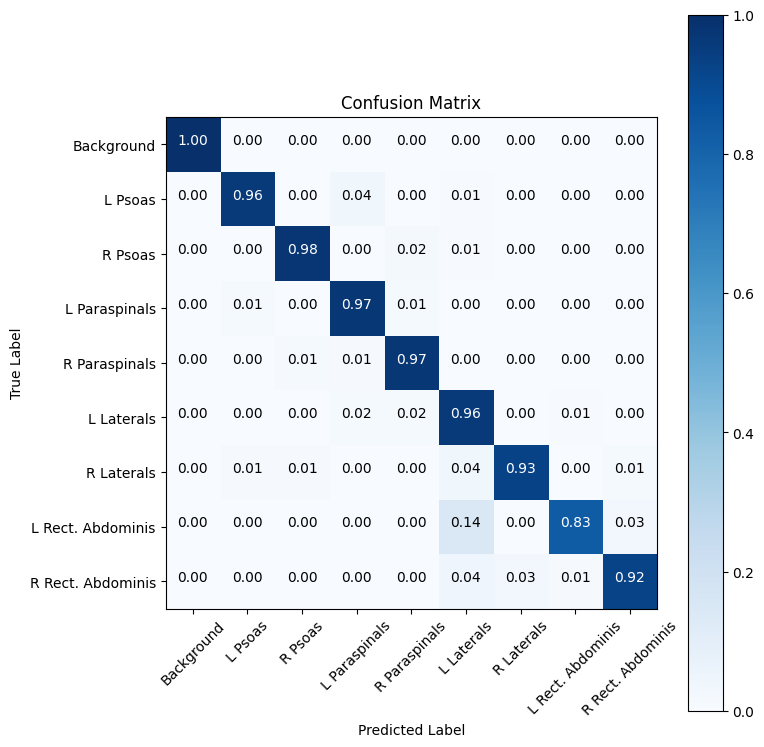

In [139]:
# features, labels = val_dataset

# data, labels = val_dataset
data_list, label_list = [], []
for d, l in processed_image_ds_test:
    data_list.append(d.numpy())
    label_list.append(l.numpy())

# Convert lists to tensors
data_tensor = tf.convert_to_tensor(data_list)
labels_tensor = tf.convert_to_tensor(label_list)

predictions = loaded_model.predict(data_tensor)
# pred_mask = model.predict(image, batch_size=1)

predictions = tf.argmax(predictions, axis=-1)
labels = tf.reshape(labels_tensor, [-1])
predictions = tf.reshape(predictions, [-1])
# Compute confusion matrix
cm = tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=9
).numpy()

# Plot the confusion matrix
# figure = plot_confusion_matrix(cm, class_names=[f"Class {i}" for i in range(9)])
class_names=[f"Class {i}" for i in range(9)]
class_names=["Background", "L Psoas", "R Psoas", "L Paraspinals", "R Paraspinals", "L Laterals", "R Laterals", 'L Rect. Abdominis', "R Rect. Abdominis"]
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix

# Annotate cells with values
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:.2f}",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

In [140]:
# log_confusion_matrix(loaded_model,val_dataset)

In [141]:
# show_predictions(loaded_model,val_dataset,1)

In [142]:
# loaded_model.summary()

In [143]:
def worst_per_examples(model, dataset):
    # features, labels = dataset
    data_list, label_list = [], []
    for d, l in dataset:
        data_list.append(d.numpy())
        label_list.append(l.numpy())


    # Convert lists to tensors
    data_tensor = tf.convert_to_tensor(data_list)
    labels_tensor = tf.convert_to_tensor(label_list)
    predictions = model.predict(data_tensor)
    
    # loss_fn = tf.keras.losses.get(model.loss)
    # print(len(data_list))
    example_losses = np.zeros((len(data_list)))
    for i, (label, prediction) in enumerate(zip(labels_tensor,predictions)):
        # print(i)
        example_losses[i] = dice_dist_multilabel(tf.expand_dims(label,axis=0), tf.expand_dims(prediction,axis=0)).numpy()
    
    worst_indices = np.argsort(-example_losses)  # Sort in descending order
    # print(len(example_losses))
    # Optionally: Get the worst N examples (e.g., top 5)
    top_n = 5
    worst_n_indices = worst_indices[:top_n]
    worst_n_losses = example_losses[worst_n_indices]
    # print(worst_n_losses)
    for i in range(5):
        show_predictions(model,((tf.expand_dims(data_tensor[worst_n_indices[i]], axis=0)),tf.expand_dims(labels_tensor[worst_n_indices[i]],axis=0)), num=1)


In [144]:
# worst_per_examples(loaded_model,processed_image_ds_val)


In [145]:
def dice_multilabel_results(y_true, y_pred, numLabels=9):
    dice = np.zeros(numLabels)
    y_true_one_hot =  tf.one_hot(tf.cast(y_true,tf.uint8), depth=numLabels, axis=-1)
    for index in range(numLabels):
        # dice -= dice_coef(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index])
        # weight = 1/ tf.keras.backend.sum(tf.keras.backend.flatten(y_true_one_hot[:,:,:,index]))
        dice[index] =  dice_coef(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index])
    
    return dice
        
def average_dice(model, dataset):
    # features, labels = dataset
    data_list, label_list = [], []
    for d, l in dataset:
        data_list.append(d.numpy())
        label_list.append(l.numpy())

    # Convert lists to tensors
    data_tensor = tf.convert_to_tensor(data_list)
    labels_tensor = tf.convert_to_tensor(label_list)
    predictions = model.predict(data_tensor)
    

    example_dices = np.zeros((len(data_list),9))
    for i, (label, prediction) in enumerate(zip(labels_tensor,predictions)):
        example_dices[i,:] = dice_multilabel_results(tf.expand_dims(label,axis=0), tf.expand_dims(prediction,axis=0))
    
    return example_dices
    

In [146]:
# dice_val = average_dice(loaded_model,processed_img_ds_train)
# dice_val_average = np.mean(dice_val,axis=0)
# print(dice_val_average)

In [147]:
# plt.boxplot(dice_val[:,1:],showfliers=False)
# plt.title('Dice Scores for Each Muscle Subgroup')
# # class_names=["L Psoas", "R Psoas", "L Paraspinals", "R Paraspinals", "L Laterals", "R Laterals", 'L Rect. Abdominis', "R Rect. Abdominis"]
# plt.xlabel('Muscle Subgroups (Classes)')
# plt.ylabel('Dice Scores [0 to 1]')

In [148]:
# from keras import backend as K
def csa(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    # intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return tf.keras.backend.sum(y_pred_f)/(tf.keras.backend.sum(y_true_f) + smooth)

def csa_multilabel_results(y_true, y_pred, numLabels=9):
    csa_est = np.zeros(numLabels)
    y_true_one_hot =  tf.one_hot(tf.cast(y_true,tf.uint8), depth=numLabels, axis=-1)
    for index in range(numLabels):

        csa_est[index] =  csa(y_true_one_hot[:,:,:,index], y_pred[:,:,:,index])
    
    return csa_est
        
def average_csa(model, dataset):
    # features, labels = dataset
    data_list, label_list = [], []
    for d, l in dataset:
        data_list.append(d.numpy())
        label_list.append(l.numpy())

    # Convert lists to tensors
    data_tensor = tf.convert_to_tensor(data_list)
    labels_tensor = tf.convert_to_tensor(label_list)
    predictions = model.predict(data_tensor)
    

    example_csa = np.zeros((len(data_list),9))
    for i, (label, prediction) in enumerate(zip(labels_tensor,predictions)):
        example_csa[i,:] = csa_multilabel_results(tf.expand_dims(label,axis=0), tf.expand_dims(prediction,axis=0))
    
    return example_csa

In [149]:
import pandas as pd

dice_train = average_dice(loaded_model,processed_img_ds_train)
dice_train_pd = pd.DataFrame(dice_train,columns=class_names)
dice_train_pd['Type'] = 'Train'

dice_val = average_dice(loaded_model,processed_image_ds_val)
dice_val_pd = pd.DataFrame(dice_val,columns=class_names)
dice_val_pd['Type'] = 'Val'

dice_test = average_dice(loaded_model,processed_image_ds_test)
dice_test_pd = pd.DataFrame(dice_test,columns=class_names)
dice_test_pd['Type'] = 'Test'

2024-12-02 14:25:36.527842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [158,512,512]
	 [[{{node Placeholder/_1}}]]


5/5 [==============================] - 1s 273ms/step


2024-12-02 14:26:42.794181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,512,512]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 43ms/step


In [150]:
dice_examples = pd.concat([dice_train_pd, dice_val_pd, dice_test_pd], ignore_index=True)
data_melted = dice_examples.melt(id_vars='Type', var_name='Class', value_name='Dice Score [0 to 1]')


Text(0.5, 1.0, 'best_model_dice_dist_2x_beg.keras')

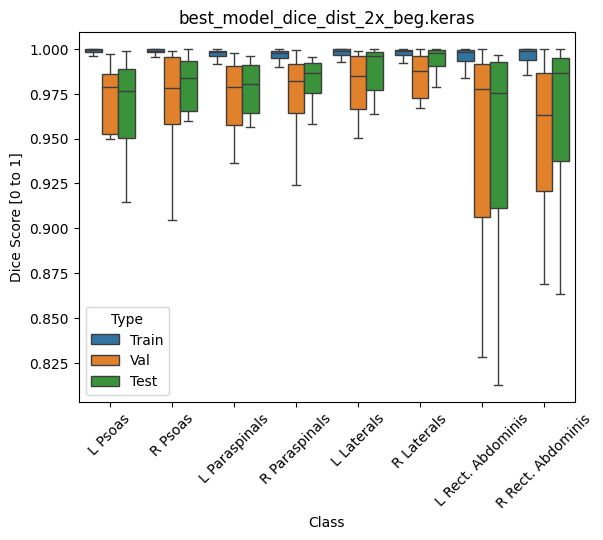

In [151]:
import seaborn as sns

sns.boxplot(data=data_melted[data_melted['Class'] != 'Background'], x='Class',y='Dice Score [0 to 1]',hue='Type', showfliers=False)
plt.xticks(rotation=45)
plt.title(model_file)


In [152]:
csa_train = average_csa(loaded_model,processed_img_ds_train)
csa_train_pd = pd.DataFrame(csa_train,columns=class_names)
csa_train_pd['Type'] = 'Train'

csa_val = average_csa(loaded_model,processed_image_ds_val)
csa_val_pd = pd.DataFrame(csa_val,columns=class_names)
csa_val_pd['Type'] = 'Val'

csa_test = average_csa(loaded_model,processed_image_ds_test)
csa_test_pd = pd.DataFrame(csa_test,columns=class_names)
csa_test_pd['Type'] = 'Test'

1/1 [==============================] - 0s 70ms/step


Text(0.5, 1.0, 'best_model_dice_dist_2x_beg.keras')

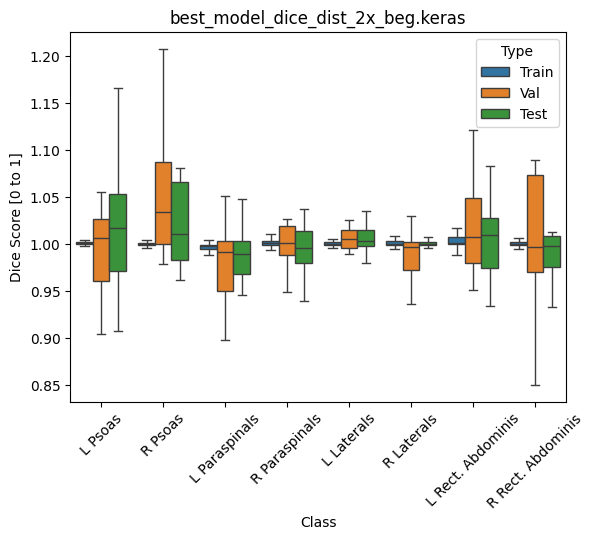

In [153]:
csa_examples = pd.concat([csa_train_pd, csa_val_pd, csa_test_pd], ignore_index=True)
csa_melted = csa_examples.melt(id_vars='Type', var_name='Class', value_name='Dice Score [0 to 1]')

sns.boxplot(data=csa_melted[csa_melted['Class'] != 'Background'], x='Class',y='Dice Score [0 to 1]',hue='Type', showfliers=False)
plt.xticks(rotation=45)
plt.title(model_file)


In [154]:
csa_examples.to_csv('csa_vals'+model_file[:-5]+'.csv')
dice_examples.to_csv('dice_vals'+model_file[:-5]+'.csv')